# Working with DSing Audio

The full dataset is located here: ../sing_300x30x2/<br>

## Automatic Lyric Transcription (ALT) tasks with DSing

To use the DSing dataset for ALT, the data is parsed using preprocessing scripts [here](https://github.com/groadabike/Kaldi-Dsing-task): 

Reading data from DSing Dataset.  Filesystem formatted this way to convert easily to huggingface dataset.<br>

where: <br>
dev/test/trainX are datasets split.<br>
\[split\]_text contains transcript for the snippet.<br>
\[split\]_spk2gender contains information about gender for snippet.<br>

Tests Split: 480 Utterances, 48 minutes<br>
Dev Split: 482 Utterances, 41 minutes<br>
Train1 Split: 8794 Utterances, 15.1 hours<br>
Train3 Split: 25526 Utterances, 44.7 hours<br>
Train30 Split: 268,392 Utterances, 149.1 hours<br>

sing_300x30x2/dataset/<br>
├── dev/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── dev_spk2gender<br>
├── dev_text<br>
├── test/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── test_spk2gender<br>
├── test_text<br>
├── train1/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── train1_spk2gender<br>
├── train1_text<br>
├── train3/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── train3_spk2gender<br>
└── train3_text<br>
├── train30/<br>
├───| metadata.csv<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;| \<audio files\>.wav<br>
├── train30_spk2gender<br>
├── train30_text<br>

In [185]:
import os
import glob

import pandas as pd
import IPython
import torch
import torchaudio
import tqdm

from IPython.display import Audio

from eda_helpers import print_stats, plot_waveform, plot_specgram, play_audio

print(f"Pytorch Version {torch.__version__}")
print(f"Pytorch Audio Version {torchaudio.__version__}")

Pytorch Version 2.2.1
Pytorch Audio Version 2.2.1


In [14]:
# read in a file from DSing
dataset_folder = "../sing_300x30x2/damp_dataset"
example_song = "../sing_300x30x2/US/USVocals/474572_111629-104344626_1690826486-US-M-1410316473.m4a"
filename = example_song

## Parse all Dataset Metadata


In [15]:
dsing_metadata = pd.read_csv('../sing_300x30x2/sing.perfs.csv')
dsing_metadata.columns = dsing_metadata.columns.str.strip()
dsing_metadata['country'].str.strip()
print(dsing_metadata.shape)
dsing_metadata.head()

(18676, 28)


,arrangement_id,starts_joins,performance_id,account_id,country,locale,latitude,longitude,city_id,gender,...,num_this_plyr,listens,loves,rec_starts,song_sing_restarts,song_review_restarts,total_user_perfs,app_inst_days,followers,followees
0,3771075_3771075,14486,1016328445_1097466956,661338667,AE,en_AE,-12.05,-75.20,3939459,F,...,1,38,0,54,1,0,3,494,16,15
1,3771075_3771075,14486,1016328445_1677743218,1099329320,AE,en_AE,37.78,-122.39,5391959,M,...,1,14,0,28,15,7,202,211,92,348
2,826432225_2362580,13156,1026791490_1692870547,1376546508,AE,en_AE,25.33,55.40,292672,F,...,1,19,0,11,2,7,3,30,65,39
3,826432225_2362580,13156,1238489945_1599597602,1356067215,AE,en_AE,37.78,-122.39,5391959,M,...,1,26,0,70,21,0,32,28,8,23
4,826432225_2366793,12430,1249009525_1541564344,1165231088,AE,en_AE,37.78,-122.39,5391959,F,...,1,26,0,17,10,0,12,203,4,8


In [16]:
dsing_metadata.columns

Index(['arrangement_id', 'starts_joins', 'performance_id', 'account_id',
       'country', 'locale', 'latitude', 'longitude', 'city_id', 'gender',
       'birth_year', 'creation_timestamp', 'device_os', 'headphones', 'efx',
       'video', 'ens_type', 'num_tracks', 'num_this_plyr', 'listens', 'loves',
       'rec_starts', 'song_sing_restarts', 'song_review_restarts',
       'total_user_perfs', 'app_inst_days', 'followers', 'followees'],
      dtype='object')

## Play from Song

AudioMetaData(sample_rate=22050, num_frames=5575936, num_channels=1, bits_per_sample=0, encoding=VORBIS)


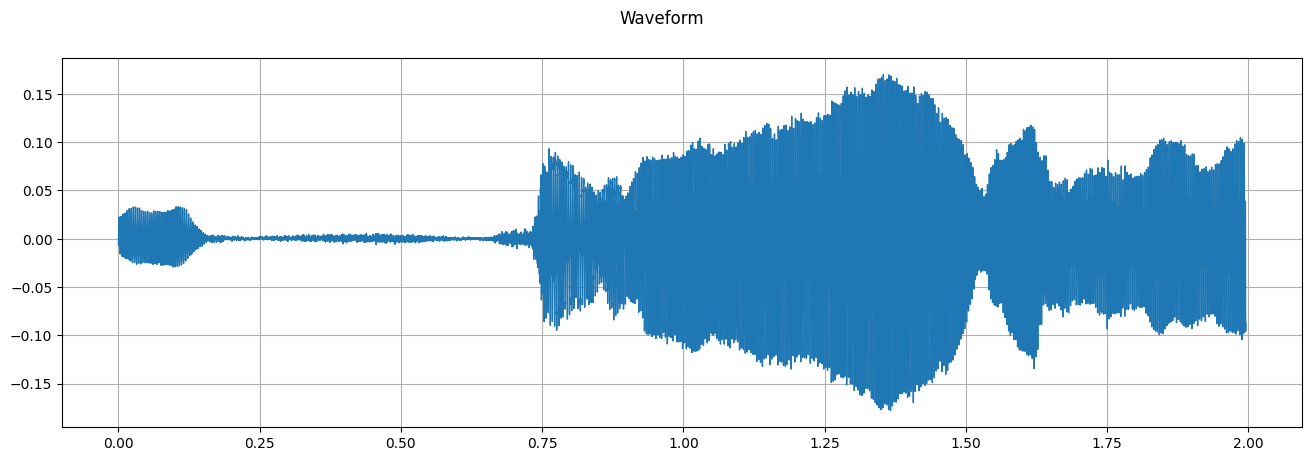

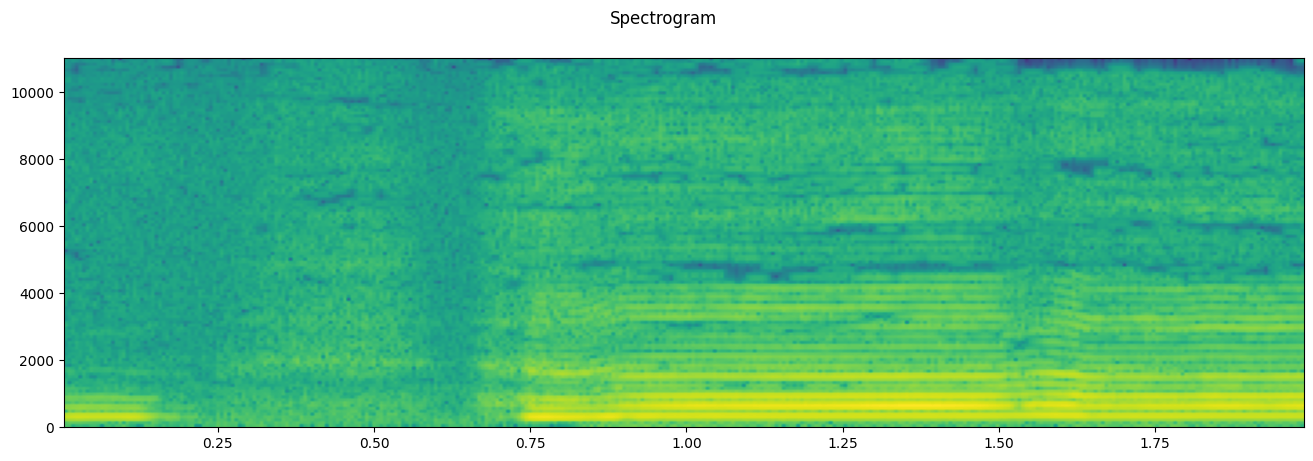

In [17]:
#read in samples from file...
metadata = torchaudio.info(filename)
print(metadata)

waveform, sample_rate = torchaudio.load(filename,frame_offset=100000,num_frames=44000);

#print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

# Find ALT Splits

In [18]:
def find_wav_files(path):
    """
    Find all .wav files in the specified directory and its subdirectories.
    
    Args:
    - directory (str): The directory path to search for .wav files.
    
    Returns:
    - List of strings: Paths to all .wav files found.
    """
    # Define the pattern to search for .wav files
    pattern = os.path.join(path, '*.wav')
    # Use glob to find all files matching the pattern
    wav_files = glob.glob(pattern, recursive=False)
    
    return [os.path.basename(path) for path in wav_files]

def find_split_duration(utt_folder,wav_files):
    duration_seconds = 0.
    for wav_file in tqdm.tqdm(wav_files):
        FILE = utt_folder + "/" + wav_file
        data_waveform, data_sample_rate = torchaudio.load(FILE)
        duration_seconds += data_waveform.shape[1] / data_sample_rate
    return duration_seconds / 60, duration_seconds / 3600 

def collect_split_durations(utt_folder,wav_files):
    duration_seconds = []
    for wav_file in tqdm.tqdm(wav_files):
        FILE = utt_folder + "/" + wav_file
        data_waveform, data_sample_rate = torchaudio.load(FILE)
        duration_seconds.append(data_waveform.shape[1] / data_sample_rate)
    return duration_seconds


In [19]:
for split in ['test','dev','train1']:
    utt_folder  = dataset_folder + f"/{split}"
    wav_files = find_wav_files(utt_folder)
    d_min, d_hours = find_split_duration(utt_folder,wav_files)
    print(f"{split} Split: {len(wav_files)} files found.")
    if split == 'test' or split=='dev':
        print(f"{split} Split: {d_min:.1f} min.")
    else: 
        print(f"{split} Split: {d_hours:.1f} hours.")

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:03<00:00, 128.56it/s]


test Split: 480 files found.
test Split: 48.0 min.


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 482/482 [00:03<00:00, 136.30it/s]


dev Split: 482 files found.
dev Split: 41.1 min.


100%|███████████████████████████████████████████████████████████████████████████████████████████| 8794/8794 [01:01<00:00, 142.44it/s]

train1 Split: 8794 files found.
train1 Split: 15.1 hours.


In [20]:
durations = {'test':[],'dev':[]}
for split in ['test','dev','train1']:
    utt_folder  = dataset_folder + f"/{split}"
    wav_files = find_wav_files(utt_folder)
    durations[split] = collect_split_durations(utt_folder,wav_files)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8794/8794 [01:02<00:00, 141.26it/s]


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.DataFrame(durations['train1'])
print(df.shape)
df2 = df[df[0] < 28.0]
print(df2.shape)

(8794, 1)
(8605, 1)


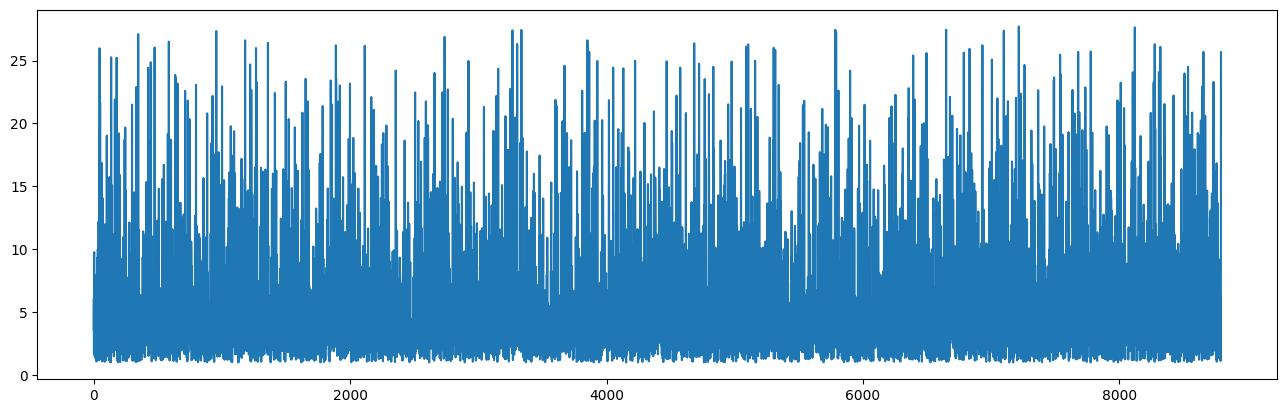

In [58]:
plt.plot(df2)

0    1.001
dtype: float64


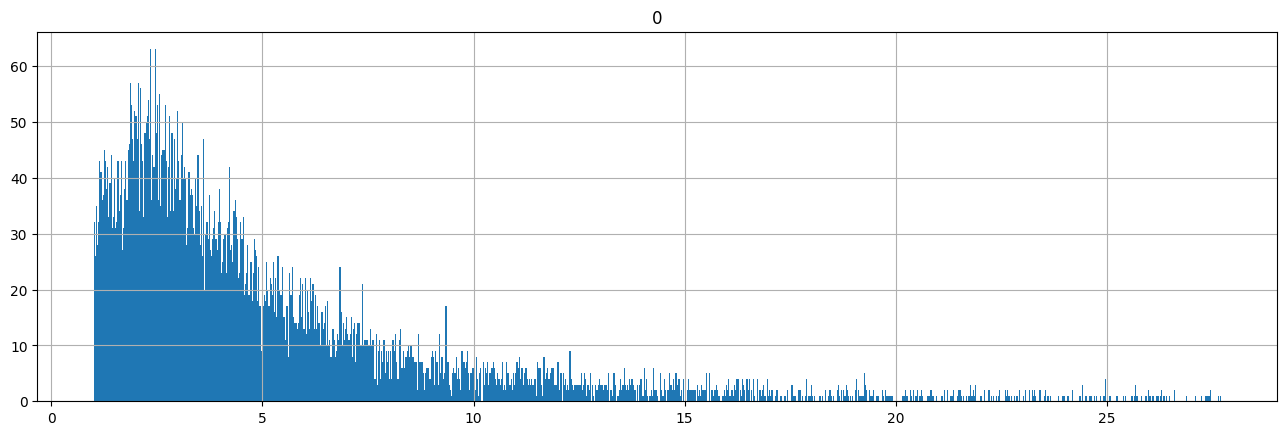

In [191]:
df2.hist(bins=1000)
print(df2.min())

In [156]:
df2.shape

(8605, 1)

In [157]:
df3 = pd.read_csv('metadata.csv')
df3

,file_name,transcription
0,F510321798-583966275_1766981-646037038_1667640...,KID HONESTLY I CAN GO ON AND ON I CAN EXPLAIN ...
1,M853667763-3771973_3771973-1326762913_16213823...,ONCE MORE YOU OPEN THE DOOR AND YOU'RE HERE IN...
2,F715584554-3769646_3769646-1221818620_16335197...,NOW I'LL NEVER NEVER GET TO CLEAN UP THE MESS ...
3,M448151779-397162491_2145545-888331738_1560191...,AND NOW MY BEDSHEETS SMELL LIKE YOU EVERY DAY ...
4,M1335982530-370582646_496045-1335601944_157272...,NOW LAY THE CHANCE
...,...,...
8600,F561431582-3259626_3259626-561426843_169425776...,DON'T WANNA WAKE UP ONE DAY WISHING THAT WE DO...
8601,F1352873680-109279600_143939-858392536_1591199...,NEVER MIND I'LL FIND SOMEONE LIKE YOU I WISH N...
8602,F290144460-804853875_1026743-290148081_1667788...,YOU KEEP ON BUILDING LIES THAT YOU MAKE UP FOR...
8603,F877651377-90470934_2940068-522188316_15498295...,I'M NOT JUST A PRETTY GIRL


In [171]:
ds3 = df3['transcription'].str.split(' ').str.len()
df3_lens = pd.DataFrame(ds3)
df3_lens

,transcription
0,35
1,20
2,13
3,27
4,4
...,...
8600,19
8601,21
8602,14
8603,6


In [173]:
df3_lens[df3_lens['transcription']==1]

,transcription
13,1
16,1
54,1
124,1
183,1
...,...
8447,1
8451,1
8538,1
8564,1


In [189]:
INDEX=183
display(df3.iloc[INDEX])
display(Audio(f"../sing_300x30x2/damp_dataset/train1/{df3.iloc[INDEX]['file_name']}", rate=int(16000)))

file_name        M472508547-273712733_115362-472505879_16044761...
transcription                                           HALLELUJAH
Name: 183, dtype: object